In [1]:
from __future__ import absolute_import, division, print_function

import numpy as np
%load_ext autoreload
%autoreload 2

import sys, os
script_dir  = os.path.normpath(os.path.abspath("."))
root_dir    = os.path.normpath(os.path.abspath(script_dir + "/../.."))
if root_dir in sys.path: sys.path.remove(root_dir)
sys.path.insert(1, root_dir)

import warnings
warnings.filterwarnings("ignore")

In [310]:
import glob, pandas as pd
import tqdm, numpy as np
from IPython import display
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [ ]:
data_root = f'{root_dir}/data/AI_competition'
prep_root = f'{data_root}/preprocessed'
df_full = pd.read_excel(f'{prep_root}/full_cell_info.xlsx')

In [37]:
df_data = df_full.query('ncells != -1')
df_data = df_data[['index', 'cdate', 'fplace', 'Temperatue', 'DO', 'pH', 'salinity', 'NTU', 'ncells', 'fpath']]
df_data

,index,cdate,fplace,Temperatue,DO,pH,salinity,NTU,ncells,fpath
0,2-1-1-2-2-1001-0110011,10/01,일해,23.65,7.08,8.39,31.75,2.95,6,먹이생물/10월01일/일해/2-1-1-2-2-1001-0110011.jpg
1,2-1-1-2-2-1001-0110012,10/01,일해,23.65,7.08,8.39,31.75,2.95,11,먹이생물/10월01일/일해/2-1-1-2-2-1001-0110012.jpg
2,2-1-1-2-2-1001-0110013,10/01,일해,23.65,7.08,8.39,31.75,2.95,7,먹이생물/10월01일/일해/2-1-1-2-2-1001-0110013.jpg
3,2-1-1-2-2-1001-0110014,10/01,일해,23.65,7.08,8.39,31.75,2.95,9,먹이생물/10월01일/일해/2-1-1-2-2-1001-0110014.jpg
4,2-1-1-2-2-1001-0110015,10/01,일해,23.65,7.08,8.39,31.75,2.95,11,먹이생물/10월01일/일해/2-1-1-2-2-1001-0110015.jpg
...,...,...,...,...,...,...,...,...,...,...
123813,2-1-1-2-2-1029-0526002,10/29,고성,25.02,8.40,9.18,34.35,8.71,10,먹이생물/10월29일/고성/2-1-1-2-2-1029-0526002.jpg
123814,2-1-1-2-2-1029-0526003,10/29,고성,25.02,8.40,9.18,34.35,8.71,5,먹이생물/10월29일/고성/2-1-1-2-2-1029-0526003.jpg
123815,2-1-1-2-2-1029-0526004,10/29,고성,25.02,8.40,9.18,34.35,8.71,17,먹이생물/10월29일/고성/2-1-1-2-2-1029-0526004.jpg
123816,2-1-1-2-2-1029-0526005,10/29,고성,25.02,8.40,9.18,34.35,8.71,17,먹이생물/10월29일/고성/2-1-1-2-2-1029-0526005.jpg


In [38]:
df_data.to_excel(f'{prep_root}/final_info.xlsx', index=False)

In [52]:
df_data_day = df_data.groupby(['cdate', 'fplace']).mean().reset_index()

In [45]:
description = df_data.describe().T
display.display(description)

description1 = df_data.query('fplace=="일해"').describe().T
display.display(description1)

description2 = df_data.query('fplace=="고성"').describe().T
display.display(description2)

,count,mean,std,min,25%,50%,75%,max
Temperatue,122166.0,25.138860,0.961073,23.05,24.42,25.06,25.85,27.04
DO,122166.0,8.383283,0.611724,6.72,7.90,8.46,8.83,9.51
pH,122166.0,8.893751,0.411348,8.18,8.56,8.92,9.15,10.05
salinity,122166.0,33.568914,0.721579,31.75,33.22,33.50,34.01,34.99
NTU,122166.0,12.974223,6.611993,1.43,7.69,12.47,16.66,28.79
ncells,122170.0,125.816502,280.663421,0.00,10.00,30.00,127.00,6857.00


,count,mean,std,min,25%,50%,75%,max
Temperatue,51248.0,24.960919,1.168971,23.05,24.21,24.53,26.16,27.04
DO,51248.0,7.963050,0.524549,6.72,7.60,7.99,8.40,8.74
pH,51248.0,8.582378,0.274686,8.18,8.35,8.50,8.75,9.21
salinity,51248.0,33.216317,0.470105,31.75,33.05,33.37,33.52,34.05
NTU,51248.0,10.629293,7.126250,1.43,5.34,8.43,16.48,28.61
ncells,51249.0,138.250268,324.399640,0.00,6.00,14.00,136.00,5756.00


,count,mean,std,min,25%,50%,75%,max
Temperatue,70918.0,25.267447,0.751167,24.12,24.56,25.18,25.7300,26.99
DO,70918.0,8.686958,0.475346,7.85,8.43,8.73,8.9500,9.51
pH,70918.0,9.118761,0.340979,8.33,8.95,9.10,9.2100,10.05
salinity,70918.0,33.823714,0.763199,32.22,33.37,33.80,34.5200,34.99
NTU,70918.0,14.668757,5.636362,4.12,11.28,14.43,16.7175,28.79
ncells,70921.0,116.831601,243.839870,0.00,19.00,39.00,124.0000,6857.00


In [54]:
description = df_data_day.describe().T
display.display(description)

description1 = df_data_day.query('fplace=="일해"').describe().T
display.display(description1)

description2 = df_data_day.query('fplace=="고성"').describe().T
display.display(description2)

,count,mean,std,min,25%,50%,75%,max
Temperatue,42.0,25.163268,1.008288,23.165929,24.448928,25.015914,25.924849,26.902358
DO,42.0,8.315707,0.637809,6.752133,7.889340,8.426476,8.708832,9.466217
pH,42.0,8.857622,0.417619,8.221604,8.486563,8.878877,9.161819,9.999775
salinity,42.0,33.522395,0.713295,31.911896,33.193811,33.464830,33.825245,34.832442
NTU,42.0,12.500268,4.067054,2.977942,10.182220,12.995627,15.669799,19.758035
ncells,42.0,125.194659,74.770650,13.446959,64.145761,114.233821,151.157888,335.109691


,count,mean,std,min,25%,50%,75%,max
Temperatue,21.0,25.054693,1.207687,23.165929,24.241083,24.480324,26.240887,26.902358
DO,21.0,7.942368,0.560318,6.752133,7.598239,7.979041,8.402360,8.693467
pH,21.0,8.592338,0.277929,8.221604,8.371061,8.601664,8.764866,9.165173
salinity,21.0,33.210577,0.493903,31.911896,33.137679,33.376642,33.549833,33.877800
NTU,21.0,10.343747,3.574648,2.977942,7.944027,12.302555,13.140462,14.347167
ncells,21.0,133.953950,82.919471,13.446959,88.584141,115.749191,145.567315,335.109691


,count,mean,std,min,25%,50%,75%,max
Temperatue,21.0,25.271842,0.775151,24.240590,24.500128,25.245567,25.756291,26.835832
DO,21.0,8.689045,0.476744,7.889322,8.450591,8.713483,8.954801,9.466217
pH,21.0,9.122906,0.364003,8.370688,8.975225,9.064552,9.175389,9.999775
salinity,21.0,33.834212,0.771295,32.383839,33.414698,33.806944,34.490767,34.832442
NTU,21.0,14.656789,3.371137,8.437562,11.199009,15.741445,16.619244,19.758035
ncells,21.0,116.435368,66.513691,36.056250,61.563032,107.412374,153.021413,261.334647


<Figure size 864x1440 with 0 Axes>

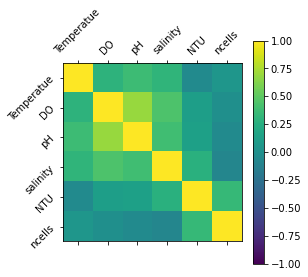

In [76]:
plt.figure(figsize=(12,20))
plt.matshow(df_data.corr(),vmin = -1, vmax = 1)
plt.colorbar()
plt.xticks(np.arange(0,6), rotation = 45);
plt.yticks(np.arange(0,6), rotation = 45);
plt.gca().set_xticklabels(list(df_data.columns[3:9]));
plt.gca().set_yticklabels(list(df_data.columns[3:9]));
plt.show()

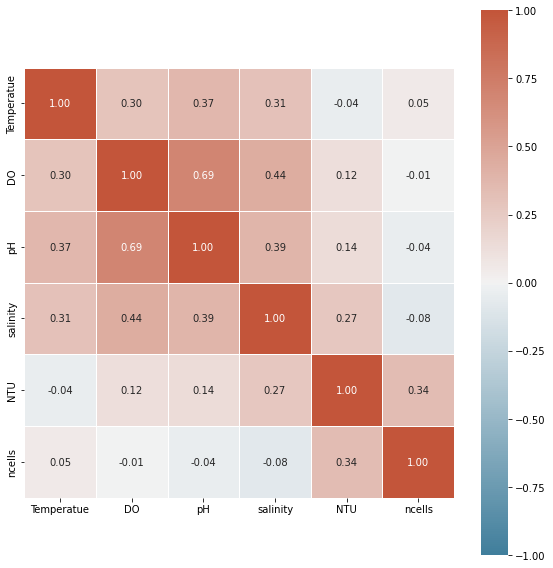

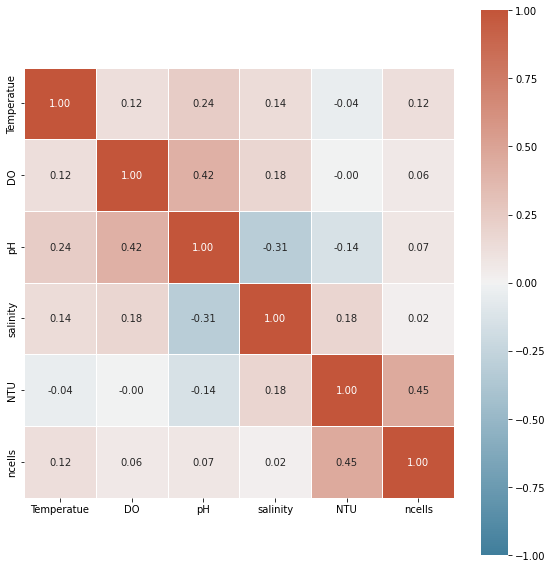

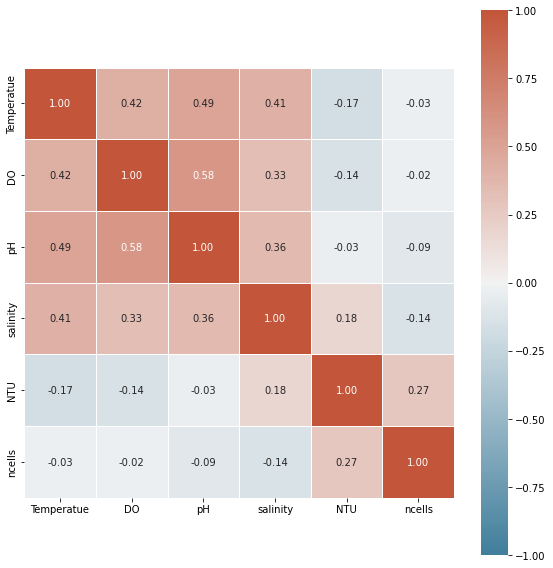

In [102]:
plt.figure(figsize=(8, 8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df_data.corr(), cmap = cmap, vmin = -1, vmax = 1,
            center = 0, square=True, linewidths=.5, annot=True, fmt=".2f")
plt.tight_layout()
plt.savefig(f'{data_root}/data_corr_all_place.png')

plt.figure(figsize=(8, 8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df_data.query('fplace=="일해"').corr(), cmap = cmap, vmin = -1, vmax = 1,
            center = 0, square=True, linewidths=.5, annot=True, fmt=".2f")
plt.tight_layout()
plt.savefig(f'{data_root}/data_corr_일해.png')

plt.figure(figsize=(8, 8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df_data.query('fplace=="고성"').corr(), cmap = cmap, vmin = -1, vmax = 1,
            center = 0, square=True, linewidths=.5, annot=True, fmt=".2f")
plt.tight_layout()
plt.savefig(f'{data_root}/data_corr_고성.png')

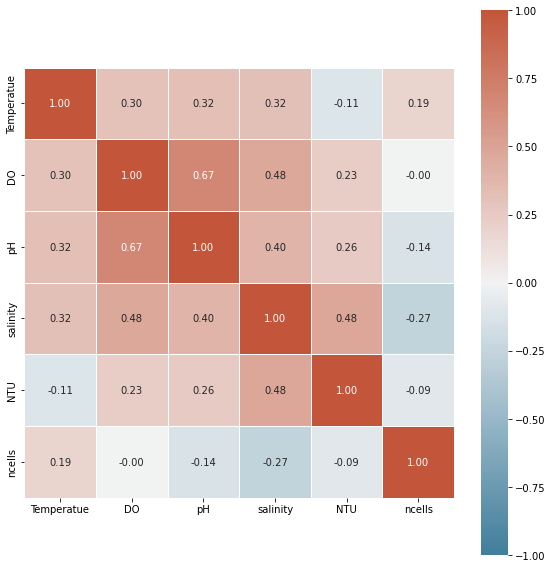

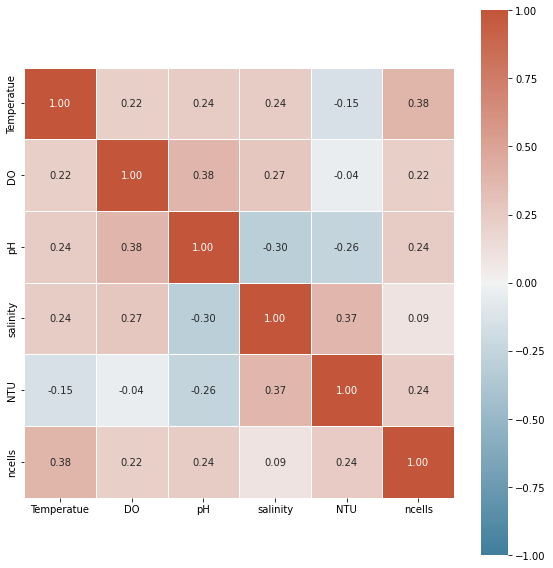

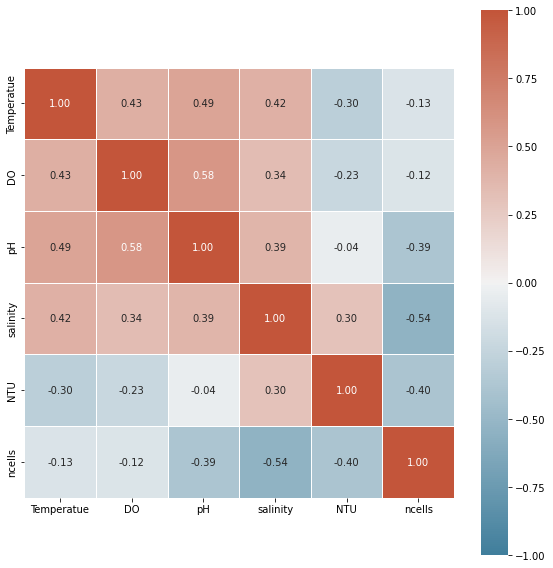

In [105]:
plt.figure(figsize=(8, 8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df_data_day.corr(), cmap = cmap, vmin = -1, vmax = 1,
            center = 0, square=True, linewidths=.5, annot=True, fmt=".2f")
plt.tight_layout()
plt.savefig(f'{data_root}/data_day_corr_all_place.png')

plt.figure(figsize=(8, 8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df_data_day.query('fplace=="일해"').corr(), cmap = cmap, vmin = -1, vmax = 1,
            center = 0, square=True, linewidths=.5, annot=True, fmt=".2f")
plt.tight_layout()
plt.savefig(f'{data_root}/data_day_corr_일해.png')

plt.figure(figsize=(8, 8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df_data_day.query('fplace=="고성"').corr(), cmap = cmap, vmin = -1, vmax = 1,
            center = 0, square=True, linewidths=.5, annot=True, fmt=".2f")
plt.tight_layout()
plt.savefig(f'{data_root}/data_day_corr_고성.png')

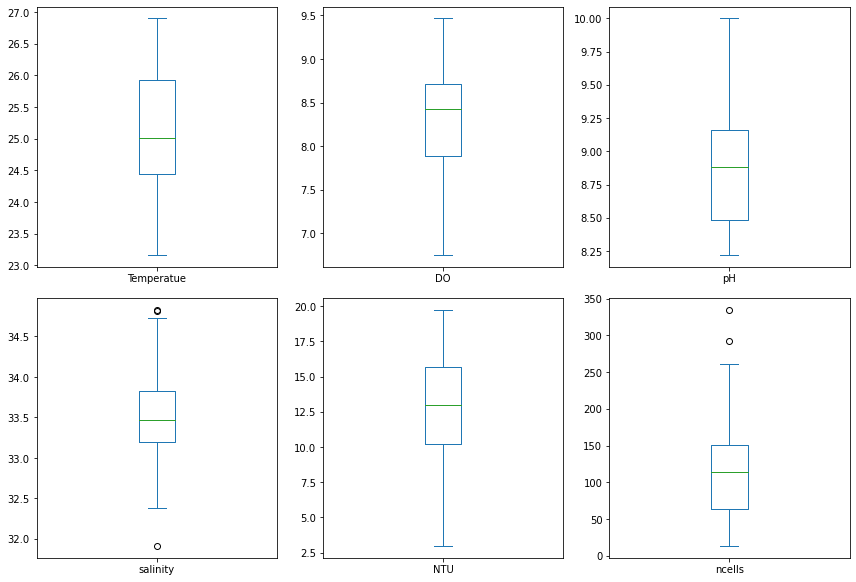

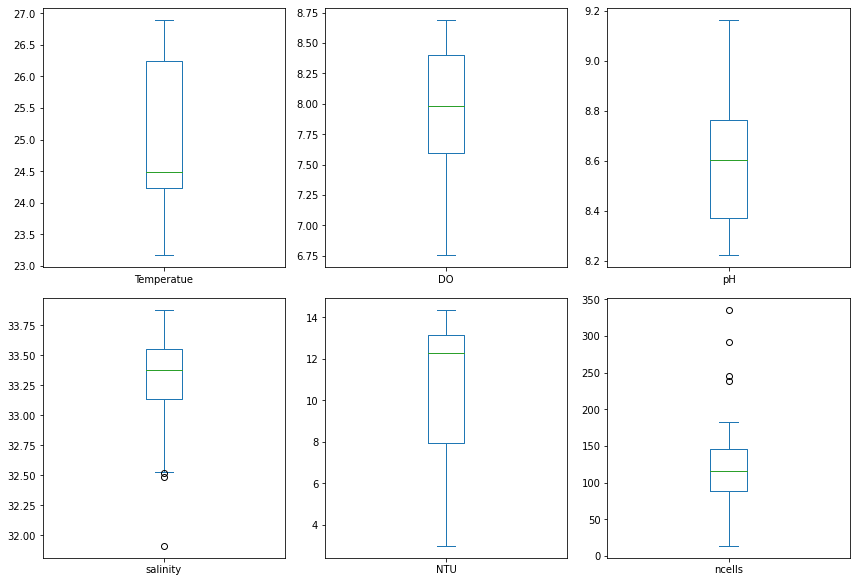

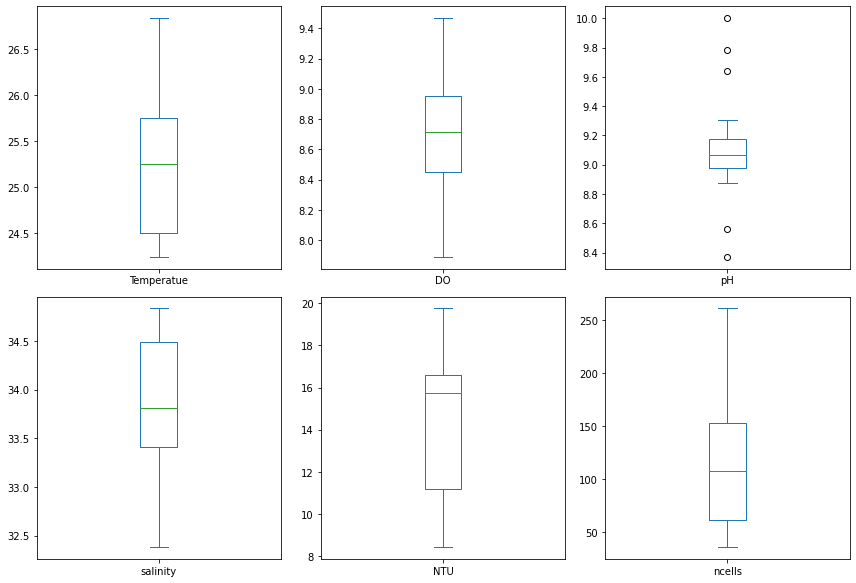

In [135]:
# df_data_day.plot(kind='density', subplots=True, layout=(3,3), sharex=False, figsize=(8,8))
df_data_day.plot(kind='box', sharex = False, sharey = False, figsize=(12, 12), layout=(3,3), subplots = True);
plt.tight_layout()
plt.savefig(f'{data_root}/data_day_boxplot_all.png')

df_data_day.query('fplace=="일해"').plot(kind='box', sharex = False, sharey = False, figsize=(12, 12), layout=(3,3), subplots = True);
plt.tight_layout()
plt.savefig(f'{data_root}/data_day_boxplot_일해.png')


df_data_day.query('fplace=="고성"').plot(kind='box', sharex = False, sharey = False, figsize=(12, 12), layout=(3,3), subplots = True);
plt.tight_layout()
plt.savefig(f'{data_root}/data_day_boxplot_고성.png')

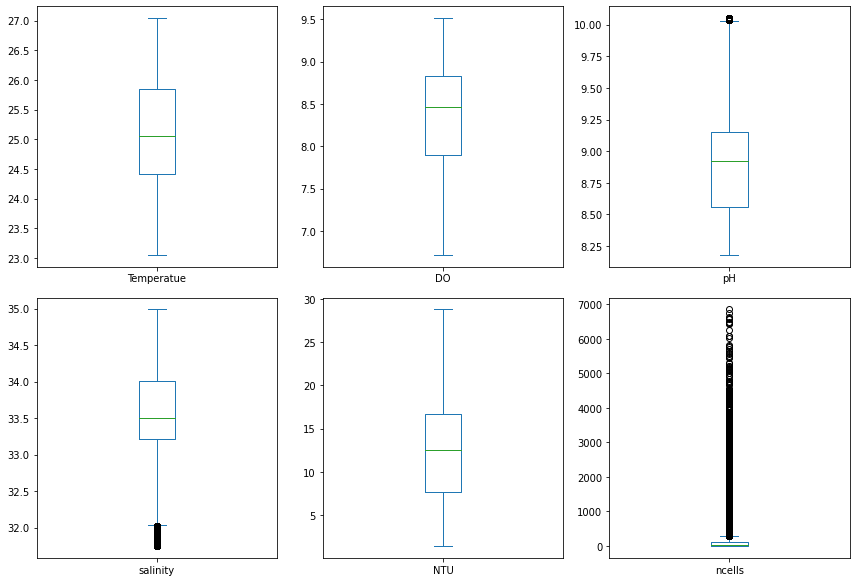

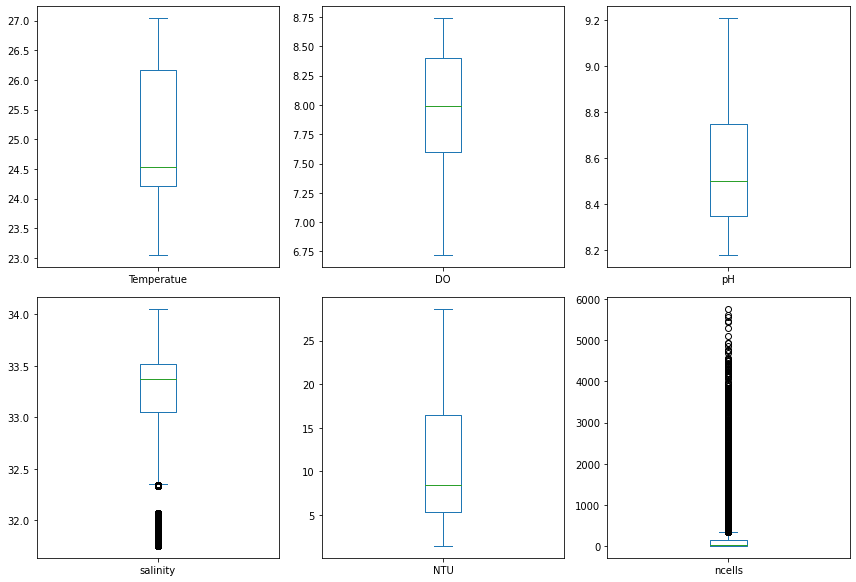

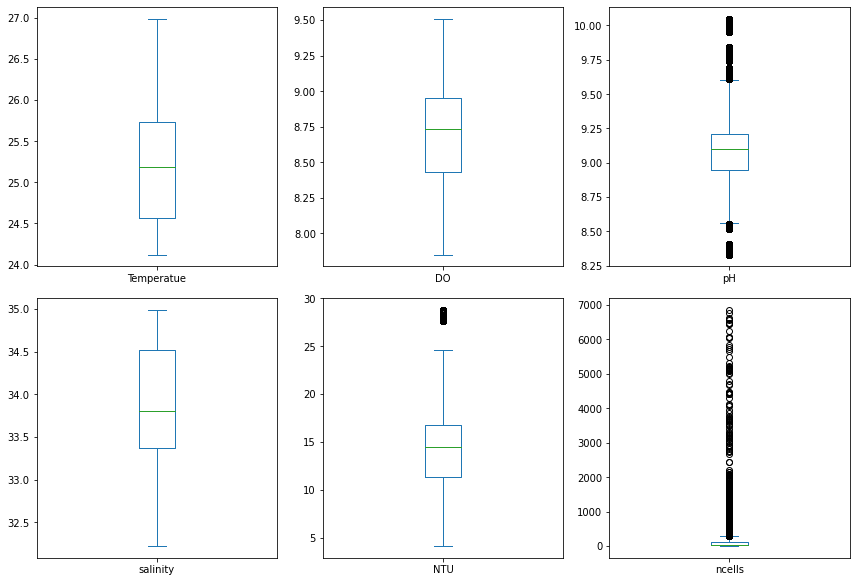

In [136]:
df_data.plot(kind='box', sharex = False, sharey = False, figsize=(12, 12), layout=(3,3), subplots = True);
plt.tight_layout()
plt.savefig(f'{data_root}/data_boxplot_all.png')

df_data.query('fplace=="일해"').plot(kind='box', sharex = False, sharey = False, figsize=(12, 12), layout=(3,3), subplots = True);
plt.tight_layout()
plt.savefig(f'{data_root}/data_boxplot_일해.png')


df_data.query('fplace=="고성"').plot(kind='box', sharex = False, sharey = False, figsize=(12, 12), layout=(3,3), subplots = True);
plt.tight_layout()
plt.savefig(f'{data_root}/data_boxplot_고성.png')

In [143]:
train_data = df_data_day.query('fplace=="고성"')[["Temperatue","DO","pH","salinity","NTU","ncells"]].values
test_data  = df_data_day.query('fplace=="일해"')[["Temperatue","DO","pH","salinity","NTU","ncells"]].values

train: (21, 5), (21,)
test:  (21, 5),  (21,)


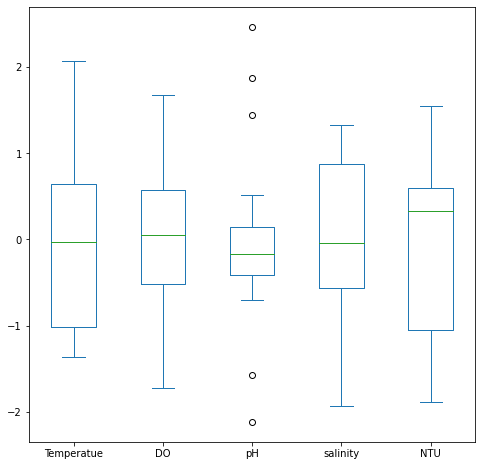

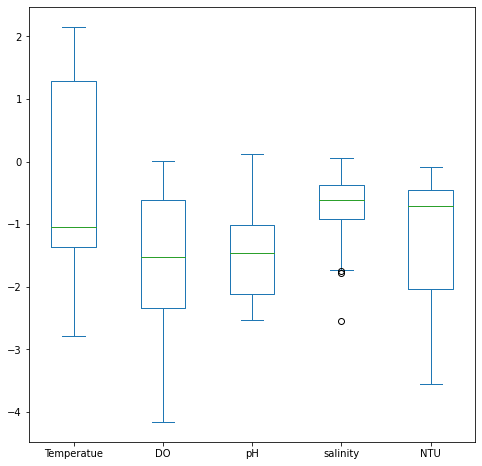

LR: 4624.864664 (3489.275387)
LASSO: 4402.204412 (3296.106496)
EN: 3849.684908 (3149.406065)
KNN: 3601.328000 (2591.995658)
CART: 4816.133333 (4053.345021)
SVR: 4416.716760 (4348.095162)


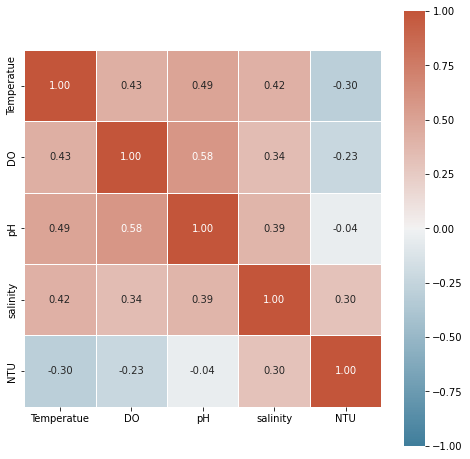

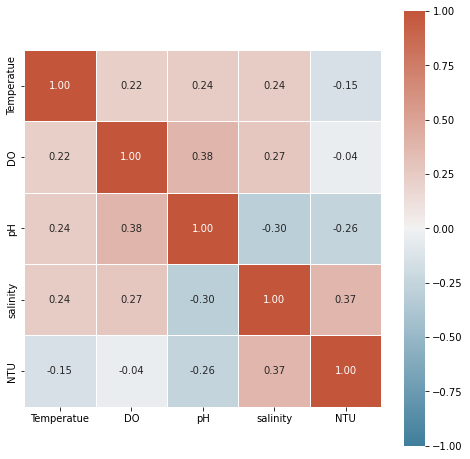

In [319]:
x_train, y_train = train_data[:, :-1], train_data[:, -1]
x_test, y_test = test_data[:, :-1], test_data[:, -1]

y_test  = np.floor(y_test)
y_train = np.floor(y_train)

print(f'train: {x_train.shape}, {y_train.shape}')
print(f'test:  {x_test.shape},  {y_test.shape}')

from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
standard_scaler.fit(x_train)

x_train = standard_scaler.transform(x_train)
x_test = standard_scaler.transform(x_test)

pd.DataFrame(x_train, columns=["Temperatue","DO","pH","salinity","NTU"]).plot(kind="box", figsize=(8,8))
plt.show()
pd.DataFrame(x_test, columns=["Temperatue","DO","pH","salinity","NTU"]).plot(kind="box", figsize=(8,8))
plt.show()

corr = pd.DataFrame(x_train, columns=["Temperatue","DO","pH","salinity","NTU"]).corr()
plt.figure(figsize=(8, 8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap = cmap, vmin = -1, vmax = 1,
            center = 0, square=True, linewidths=.5, annot=True, fmt=".2f")

corr = pd.DataFrame(x_test, columns=["Temperatue","DO","pH","salinity","NTU"]).corr()
plt.figure(figsize=(8, 8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap = cmap, vmin = -1, vmax = 1,
            center = 0, square=True, linewidths=.5, annot=True, fmt=".2f")

models = {}
models['LR'] = LinearRegression()
models['LASSO'] = Lasso()
models['EN'] = ElasticNet()
models['KNN'] = KNeighborsRegressor()
models['CART'] = DecisionTreeRegressor()
models['SVR'] = SVR()

# evaluate each model in turn
scoring = 'neg_mean_squared_error'
# scoring = 'neg_mean_absolute_percentage_error'
num_folds = 10
seed = 42
results = []
names = []
for name in models:
    cv = KFold(n_splits=num_folds, random_state=seed, shuffle = True)
    # cv = LeaveOneOut()
    cv_results = cross_val_score(models[name], x_train, y_train, cv=cv, scoring=scoring)
    cv_results = np.absolute(cv_results)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

    models[name].fit(x_test, y_test)
    # pass


train: (21, 5), (21,)
test:  (21, 5),  (21,)


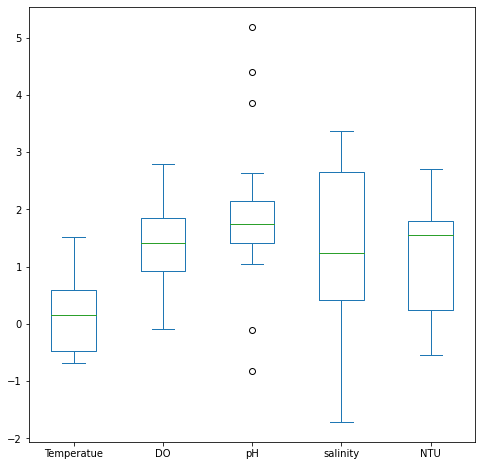

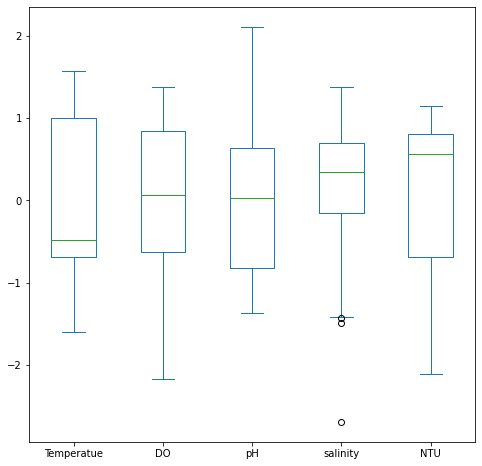

LR: 8232.651353 (5494.255328)
LASSO: 8134.531047 (5735.307733)
EN: 7424.303141 (6319.742168)
KNN: 8162.760000 (7772.820841)
CART: 10231.466667 (7945.781253)
SVR: 6963.661056 (7314.846035)


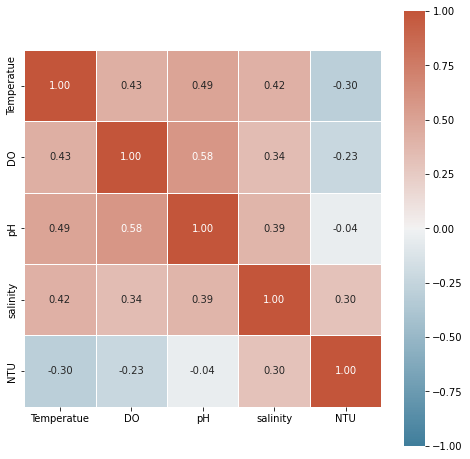

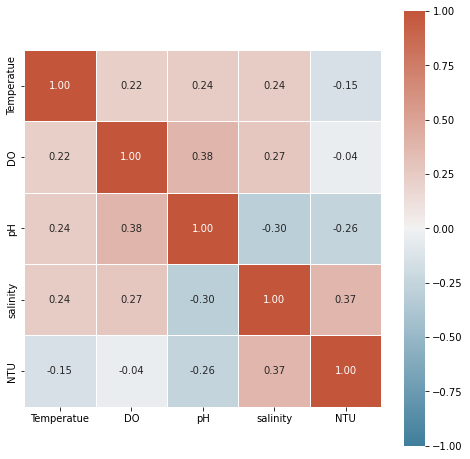

In [318]:
x_train, y_train = train_data[:, :-1], train_data[:, -1]
x_test, y_test = test_data[:, :-1], test_data[:, -1]

y_test  = np.floor(y_test)
y_train = np.floor(y_train)

print(f'train: {x_train.shape}, {y_train.shape}')
print(f'test:  {x_test.shape},  {y_test.shape}')

from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
standard_scaler.fit(x_test)

x_train = standard_scaler.transform(x_train)
x_test = standard_scaler.transform(x_test)

pd.DataFrame(x_train, columns=["Temperatue","DO","pH","salinity","NTU"]).plot(kind="box", figsize=(8,8))
plt.show()
pd.DataFrame(x_test, columns=["Temperatue","DO","pH","salinity","NTU"]).plot(kind="box", figsize=(8,8))
plt.show()

corr = pd.DataFrame(x_train, columns=["Temperatue","DO","pH","salinity","NTU"]).corr()
plt.figure(figsize=(8, 8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap = cmap, vmin = -1, vmax = 1,
            center = 0, square=True, linewidths=.5, annot=True, fmt=".2f")

corr = pd.DataFrame(x_test, columns=["Temperatue","DO","pH","salinity","NTU"]).corr()
plt.figure(figsize=(8, 8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap = cmap, vmin = -1, vmax = 1,
            center = 0, square=True, linewidths=.5, annot=True, fmt=".2f")

models = {}
models['LR'] = LinearRegression()
models['LASSO'] = Lasso()
models['EN'] = ElasticNet()
models['KNN'] = KNeighborsRegressor()
models['CART'] = DecisionTreeRegressor()
models['SVR'] = SVR()

# evaluate each model in turn
scoring = 'neg_mean_squared_error'
# scoring = 'neg_mean_absolute_percentage_error'
num_folds = 10
seed = 42
results = []
names = []
for name in models:
    cv = KFold(n_splits=num_folds, random_state=seed, shuffle = True)
    # cv = LeaveOneOut()
    cv_results = cross_val_score(models[name], x_test, y_test, cv=cv, scoring=scoring)
    cv_results = np.absolute(cv_results)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

    models[name].fit(x_test, y_test)
    # pass

In [306]:
!jupyter nbconvert 02_acellcounts_tests.ipynb --to html

[NbConvertApp] Converting notebook 02_acellcounts_tests.ipynb to html
[NbConvertApp] Writing 1095494 bytes to 02_acellcounts_tests.html
